In [1]:
from functools import partial
import jax
import jax.numpy as np
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal, ones
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve
import matplotlib.pyplot as plt

In [2]:
'''Setting up a global JAX pseudorandom nummber generator with seed value of 1. We use this fixed seed so that we can reproduce the results with random operations'''

rng = jax.random.PRNGKey(1)


In [3]:
'''A function to generate random matrices A,B,C for our random SSM. These are learnable parameters'''

def random_SSM(rng, N):
    a_r, b_r, c_r = jax.random.split(rng, 3)

    A = jax.random.uniform(a_r, shape=(N,N))
    B = jax.random.uniform(b_r, shape=(N,1))
    C = jax.random.uniform(c_r, shape=(1,N))

    return A,B,C

In [4]:
'''We need to convert the continuous-time input signals to discrete signals since generally in recurrent representations we use
   inputs like (x1,x2,x3,....) and not x(t). We discretize the signals using another learnable parameter i.e. step size. We convert
   the A,B,C state matrices to discretized matrices A_bar, B_bar, C_bar.'''


def discretize(A, B, C, step):
    I = np.eye(A.shape[0])
    BL = inv(I - (step/2.0)*A)
    A_bar = BL @ (I + (step/2.0)*A)
    B_bar = (BL*step) @ B
    C_bar = C

    return A_bar, B_bar, C_bar

In [5]:
def scan_SSM(A_bar, B_bar, C_bar, u, x0):
    def step(x_k_1, u_k):
        x_k = A_bar @ x_k_1 + B_bar @ u_k
        y_k = C_bar @ x_k

        return x_k, y_k

    return jax.lax.scan(step, x0, u)


def run_SSM(A, B, C, u):
    L = u.shape[0]
    N = A.shape[0]

    A_bar, B_bar, C_bar = discretize(A, B, C, step=1.0/L)

    return scan_SSM(A_bar, B_bar, C_bar, u[:, np.newaxis], np.zeros((N,)))[1]

In [6]:
'''Implementing the convolutional representation of SSM where we calculate the kernal called SSM convolutional kernal from matrices A_bar, B_bar, C_bar.
   This way we can do parllell computations which recurrent representation of SSM did linearly, leading to increasing training time.'''


def K_conv(A_bar, B_bar, C_bar, L):
    K = []
    for l in range(L):
        K_l = (C_bar @ matrix_power(A_bar, l) @ B_bar).reshape()
        K.append(K_l)
    return np.array(K)


'''Next we use this kernal and convolve with the input sequences using either the direct convolution or by using convolution theorem with Fast Fourier Transformer (FFT)
   Since FFT is applied usually for circular sequences (end of one sequences connect the beggining of the next), we first pad and then unpad the sequences to make it fit for our
   non-circular sequences. We convert to frequence-domain since the convolution in time-domain has more complexity than that in frequence-domain for large sequences.'''


def causal_convolution(u, kernel_K, fft=True):

    if fft == False:
        return convolve(u, kernel_K, mode='full')[:u.shape[0]]
    else:
        assert kernel_K.shape[0] == u.shape[0]

        padded_u = np.pad(u, (0, kernel_K.shape[0]))
        padded_kernel_k = np.pad(kernel_K, (0, u.shape[0]))

        # FFT: Transforming to frequence-domain representation

        ud = np.fft.rfft(padded_u)
        kd = np.fft.rfft(padded_kernel_k)

        # Matrix Multiplication

        out = ud * kd

        # Inverse FFT: Converts the result back into the time domain

        result = np.fft.irfft(out)

        return result[:u.shape[0]]

In [7]:
def test_cnn_is_rnn(N=4, L=16, step=1.0/16):
    A, B, C = random_SSM(rng, N)
    u = jax.random.uniform(rng, (L,))
    jax.random.split(rng, 3)

    # RNN
    rec = run_SSM(A, B, C, u)

    # CNN
    A_bar, B_bar, C_bar = discretize(A, B, C, step)
    ssm_kernel = K_conv(A_bar, B_bar, C_bar, L)

    conv = causal_convolution(u, ssm_kernel)

    return rec, conv

rec_res, conv_res = test_cnn_is_rnn()

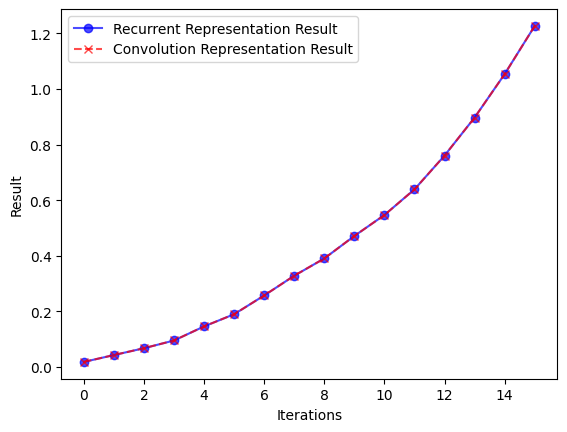

In [8]:
'''The result and plot clearly shows that CNN and the RNN method yield roughly the same result.'''

x = np.arange(len(rec_res))

plt.plot(x, rec_res.flatten(), label='Recurrent Representation Result', color='blue', linestyle='-', marker='o', markersize=6, alpha=0.7)  
plt.plot(x, conv_res.flatten(), label='Convolution Representation Result', color='red', linestyle='--', marker='x', markersize=6, alpha=0.7)   

plt.xlabel('Iterations')
plt.ylabel('Result')

plt.legend()
plt.show()


In [9]:
'''This function defines an initializer for the step size.'''

def log_step_initializer(dt_min = 0.001, dt_max = 0.1):
    def init(key, shape):
        return jax.random.uniform(key, shape) * (np.log(dt_max) - np.log(dt_min)) + np.log(dt_min)

    return init

# Sample Test
shape = (1,)
init_func = log_step_initializer()
step = init_func(rng, shape)
print(step)

[-4.8877783]


In [10]:
class SSMLayer(nn.Module):
    N: int
    l_max: int
    decode: bool = False

    def setup(self):
        self.A = self.param("A", lecun_normal(), (self.N, self.N))
        self.B = self.param("B", lecun_normal(), (self.N, 1))
        self.C = self.param("C", lecun_normal(), (1, self.N))
        self.D = self.param("D", ones(), (1,))

        # Initializing the step-size parameter
        self.log_step = self.param("log_step", log_step_initializer(), (1,))
        step = np.exp(self.log_step)

        self.ssm = discretize(self.A, self.B, self.C, step)
        self.kernal_K = K_conv(*self.ssm, self.l_max)

        # RNN cache for long sequences
        self.x_k_1 = self.variable('cache', 'cache_x_k', np.zeros, (self.N))

    def __call__(self, u):
        if not self.decode:
            # CNN mode
            return causal_convolution(u, self.kernal_K) + self.D*u
        else:
            # RNN mode
            x_k, y_s = scan_SSM(*self.ssm, u[:, np.newaxis], self.x_k_1.value)
            if self.is_mutable_collection("cache"):
                self.x_k_1 = x_k

            return y_s.reshape(-1).real + self.D*u


In [11]:
'''We use nn.vmap() to create independent & parellel copies of our SSMLayer, each operating on a different slice of input'''

def clone_layer(layer):
    return nn.vmap(
        layer,
        in_axes=1,
        out_axes=1,
        variable_axes={"params": 1, "cache": 1, "prime": 1}, 
        split_rngs={"params": True}, # Each layer gets their seperate rng keys for initializing parameters
    )

SSMLayer = clone_layer(SSMLayer)

In [12]:
class SequenceBlock(nn.Module):
    layer_cls: nn.module
    layer: dict                     # A dictionary containing hyperparameters for the layer_cls
    dropout: float                  
    d_model: int                    # Dimensionality of output features
    prenorm: bool = True            # Whether to apply LayerNorm before sequential layer
    glu: bool = True                # Gate Linear Unit for additional processing 
    training: bool  = True          
    decode: bool = False            # CNN or RNN mode

    def setup(self):
        self.seq = self.layer_cls(**self_layer, decode = self.decode)
        self.norm = nn.LayerNorm()
        self.out = nn.Dense(self.d_model)
        
        if self.glu:
            self.out2 = nn.Dense(self.d_model)
        
        self.drop = nn.Dropout(self.dropout, broadcast_dims=[0], deterministic= not self.training)

    def __call__(self, x):
        skip = x
        
        if self.prenorm:
            x = self.prenorm(x)

        x = self.seq(x)
        x = self.drop(nn.gelu(x))

        if self.glu:
            x = self.out(x) * jax.nn.sigmoid(self.out2(x))
        else:
            x = self.out(x)

        x = skip + self.drop(x)

        if not self.prenorm:
            x = self.norm(x)

        return x

            

In [13]:
class Embedding(nn.Embed):
    num_embeddings: int
    features: int

    @nn.compact
    def __call__(self, x):
        y = nn.Embed(self.num_embeddings, self.features)(x[..., 0])
        return np.where(x > 0, y, 0.0)

In [14]:
class StackedModel(nn.Module):
    layer_cls: nn.Module
    layer: dict
    d_output: int
    d_model: int
    n_layers: int
    prenorm: bool = True
    dropout: float = 0.0
    embedding: bool = False
    classification: bool = False
    training: bool = True
    decode: bool = False

    def setup(self):

        if self.embedding:
            self.encoder = Embedding(self.d_output, self.d_model)
        else:
            self.encoder = nn.Dense(self.d_model)

        self.decoder = nn.Dense(self.d_output)
        self.layers = [
            SequenceBlock(
                layer_cls = self.layer_cls,
                layer = self.layer,
                dropout = self.dropout,
                d_model = self.d_model,
                prenorm = self.prenorm,
                training = self.training,
                decoder = self.decode
            )
            for _ in range(self.n_layers)
        ]

    def __call__(self, x):
        if not self.classification:                 
            if not self.embedding:
                x = x / 255.0               #  When we are working on Image Data we divide by 255.
            if not self.decode:
                x = np.pad(x[:-1], [(1, 0), (0, 0)])
            
        x = self.encoder(x)

        for layer in self.layers:
            x = layer(x)

        if self.classification:
            x = np.mean(x, axis=0)

        x = self.decoder(x)

        return nn.log_softmax(x, axis=-1)
            


    

SyntaxError: expected '(' (2404931330.py, line 14)